# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [23]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [24]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [25]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [26]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.092


In [27]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for i in xrange(len(learning_rates)):
    for j in xrange(len(regularization_strengths)):
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rates[i], regularization_strengths[j],
                      num_iters=20000, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = svm.predict(X_val_feats)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        y_val_acc = np.mean(y_val == y_val_pred)
        y_train_acc = np.mean(y_train == y_train_pred)
        if (best_val < y_val_acc):
            best_val = y_val_acc
            print (best_val)
            best_svm = svm
        results[(learning_rates[i],  regularization_strengths[j])] = (y_train_acc, y_val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

(49000, 155)
training accuracy: 0.099592
validation accuracy: 0.085000
0.085
(49000, 155)
training accuracy: 0.414653
validation accuracy: 0.421000
0.421
(49000, 155)
training accuracy: 0.415061
validation accuracy: 0.419000
(49000, 155)
training accuracy: 0.414714
validation accuracy: 0.420000
(49000, 155)
training accuracy: 0.414980
validation accuracy: 0.413000
(49000, 155)
training accuracy: 0.409082
validation accuracy: 0.406000
(49000, 155)
training accuracy: 0.414347
validation accuracy: 0.419000
(49000, 155)
training accuracy: 0.414898
validation accuracy: 0.404000
(49000, 155)
training accuracy: 0.362551
validation accuracy: 0.359000
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.099592 val accuracy: 0.085000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.414653 val accuracy: 0.421000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.415061 val accuracy: 0.419000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.414714 val accuracy: 0.420000
lr 1.000000e-08 reg 5.000

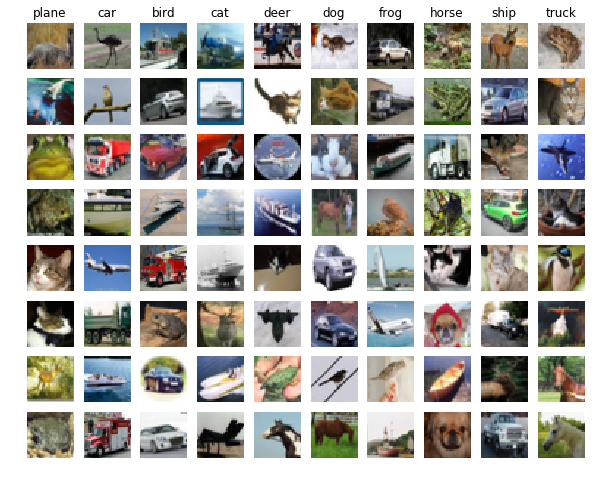

In [28]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
print(X_train_feats.shape)

iteration 0 / 3000: loss 2.302586
train_acc:  0.135
val_acc:  0.098
iteration 100 / 3000: loss 2.296536
iteration 200 / 3000: loss 2.213376
train_acc:  0.65
val_acc:  0.412
iteration 300 / 3000: loss 2.039059
iteration 400 / 3000: loss 2.076928
train_acc:  0.67
val_acc:  0.451
iteration 500 / 3000: loss 2.075940
iteration 600 / 3000: loss 2.009434
iteration 700 / 3000: loss 1.860123
train_acc:  0.62
val_acc:  0.498
iteration 800 / 3000: loss 1.803371
iteration 900 / 3000: loss 1.831241
train_acc:  0.68
val_acc:  0.455
iteration 1000 / 3000: loss 1.834093
iteration 1100 / 3000: loss 1.680001
iteration 1200 / 3000: loss 1.727639
train_acc:  0.69
val_acc:  0.489
iteration 1300 / 3000: loss 1.533628
iteration 1400 / 3000: loss 1.641302
train_acc:  0.66
val_acc:  0.488
iteration 1500 / 3000: loss 1.844357
iteration 1600 / 3000: loss 1.695174
iteration 1700 / 3000: loss 1.490592
train_acc:  0.72
val_acc:  0.517
iteration 1800 / 3000: loss 1.743129
iteration 1900 / 3000: loss 1.517846
train_a

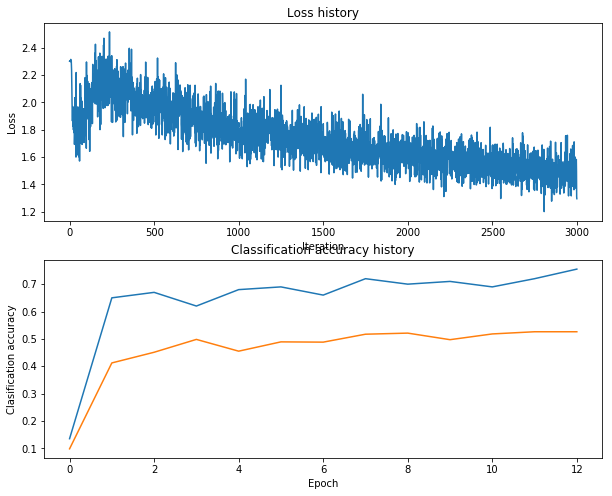

Validation accuracy:  0.542
0.542
iteration 0 / 3000: loss 2.302586
train_acc:  0.165
val_acc:  0.078
iteration 100 / 3000: loss 1.939195
iteration 200 / 3000: loss 2.065991
train_acc:  0.605
val_acc:  0.471
iteration 300 / 3000: loss 1.876508
iteration 400 / 3000: loss 2.071015
train_acc:  0.62
val_acc:  0.437
iteration 500 / 3000: loss 1.953041
iteration 600 / 3000: loss 1.910405
iteration 700 / 3000: loss 1.925733
train_acc:  0.635
val_acc:  0.444
iteration 800 / 3000: loss 1.782424
iteration 900 / 3000: loss 1.856478
train_acc:  0.655
val_acc:  0.465
iteration 1000 / 3000: loss 1.851028
iteration 1100 / 3000: loss 1.895684
iteration 1200 / 3000: loss 1.688495
train_acc:  0.685
val_acc:  0.481
iteration 1300 / 3000: loss 1.763309
iteration 1400 / 3000: loss 1.839582
train_acc:  0.625
val_acc:  0.474
iteration 1500 / 3000: loss 1.897900
iteration 1600 / 3000: loss 1.747145
iteration 1700 / 3000: loss 1.755702
train_acc:  0.52
val_acc:  0.421
iteration 1800 / 3000: loss 1.724349
itera

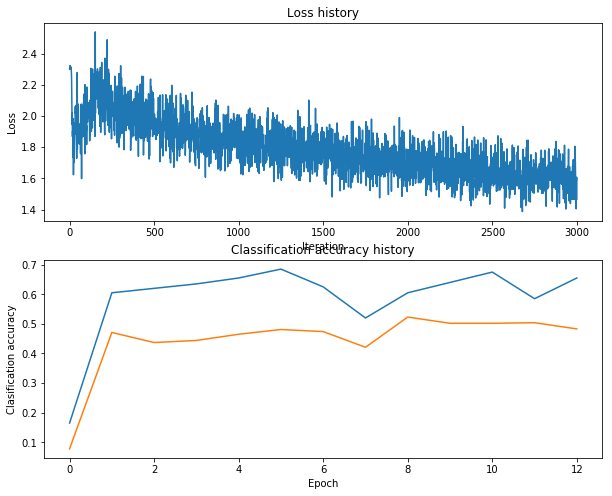

Validation accuracy:  0.514
iteration 0 / 3000: loss 2.302586
train_acc:  0.21
val_acc:  0.178
iteration 100 / 3000: loss 2.121743
iteration 200 / 3000: loss 2.290260
train_acc:  0.695
val_acc:  0.458
iteration 300 / 3000: loss 1.929010
iteration 400 / 3000: loss 2.082866
train_acc:  0.685
val_acc:  0.47
iteration 500 / 3000: loss 2.091034
iteration 600 / 3000: loss 1.915787
iteration 700 / 3000: loss 1.855171
train_acc:  0.69
val_acc:  0.46
iteration 800 / 3000: loss 1.892107
iteration 900 / 3000: loss 1.895054
train_acc:  0.69
val_acc:  0.471
iteration 1000 / 3000: loss 1.744263
iteration 1100 / 3000: loss 1.816634
iteration 1200 / 3000: loss 1.812388
train_acc:  0.67
val_acc:  0.476
iteration 1300 / 3000: loss 1.624641
iteration 1400 / 3000: loss 1.684623
train_acc:  0.655
val_acc:  0.499
iteration 1500 / 3000: loss 1.689730
iteration 1600 / 3000: loss 1.620380
iteration 1700 / 3000: loss 1.800836
train_acc:  0.74
val_acc:  0.51
iteration 1800 / 3000: loss 1.624422
iteration 1900 / 

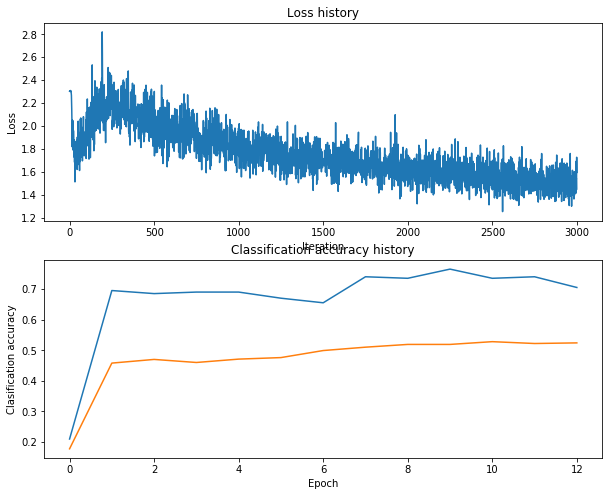

Validation accuracy:  0.554
0.554
iteration 0 / 3000: loss 2.302587
train_acc:  0.135
val_acc:  0.087
iteration 100 / 3000: loss 2.340213
iteration 200 / 3000: loss 2.178853
train_acc:  0.61
val_acc:  0.416
iteration 300 / 3000: loss 1.942737
iteration 400 / 3000: loss 1.944758
train_acc:  0.6
val_acc:  0.474
iteration 500 / 3000: loss 1.961968
iteration 600 / 3000: loss 1.885474
iteration 700 / 3000: loss 2.026874
train_acc:  0.56
val_acc:  0.461
iteration 800 / 3000: loss 1.901691
iteration 900 / 3000: loss 2.047339
train_acc:  0.625
val_acc:  0.479
iteration 1000 / 3000: loss 1.712006
iteration 1100 / 3000: loss 1.801455
iteration 1200 / 3000: loss 1.731483
train_acc:  0.585
val_acc:  0.48
iteration 1300 / 3000: loss 1.757824
iteration 1400 / 3000: loss 1.782296
train_acc:  0.63
val_acc:  0.469
iteration 1500 / 3000: loss 1.774206
iteration 1600 / 3000: loss 1.678195
iteration 1700 / 3000: loss 1.729460
train_acc:  0.645
val_acc:  0.487
iteration 1800 / 3000: loss 1.647774
iteration

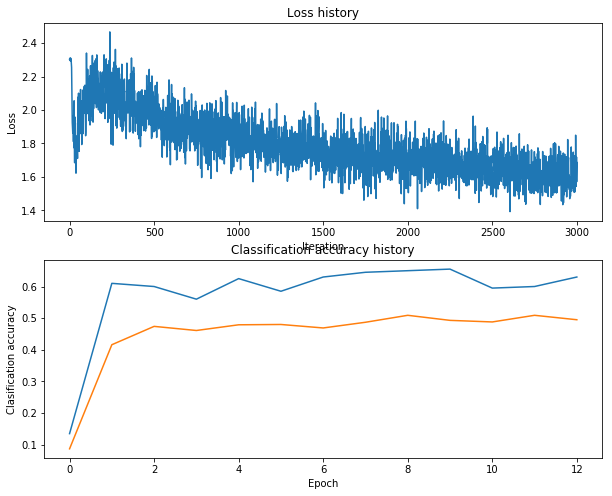

Validation accuracy:  0.52
iteration 0 / 3000: loss 2.302585
train_acc:  0.145
val_acc:  0.119
iteration 100 / 3000: loss 1.715526
iteration 200 / 3000: loss 2.161259
train_acc:  0.725
val_acc:  0.466
iteration 300 / 3000: loss 2.191299
iteration 400 / 3000: loss 2.040319
train_acc:  0.695
val_acc:  0.48
iteration 500 / 3000: loss 2.198852
iteration 600 / 3000: loss 1.874544
iteration 700 / 3000: loss 1.956512
train_acc:  0.7
val_acc:  0.494
iteration 800 / 3000: loss 1.765311
iteration 900 / 3000: loss 1.723011
train_acc:  0.695
val_acc:  0.489
iteration 1000 / 3000: loss 1.941967
iteration 1100 / 3000: loss 1.921011
iteration 1200 / 3000: loss 1.883605
train_acc:  0.67
val_acc:  0.505
iteration 1300 / 3000: loss 1.721088
iteration 1400 / 3000: loss 1.733357
train_acc:  0.735
val_acc:  0.504
iteration 1500 / 3000: loss 1.714838
iteration 1600 / 3000: loss 1.830800
iteration 1700 / 3000: loss 1.679307
train_acc:  0.71
val_acc:  0.51
iteration 1800 / 3000: loss 1.669676
iteration 1900 /

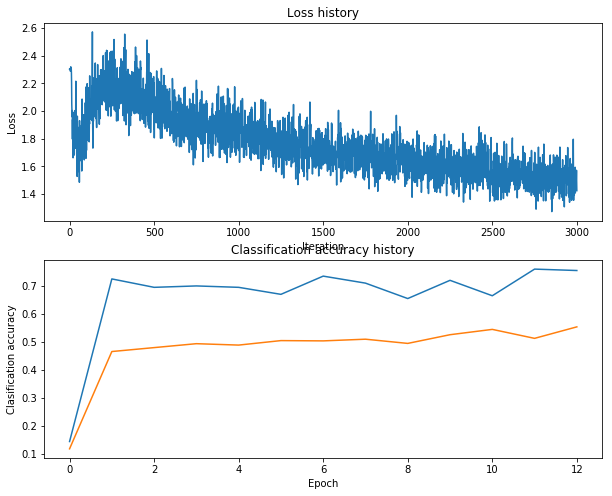

Validation accuracy:  0.568
0.568
iteration 0 / 3000: loss 2.302587
train_acc:  0.13
val_acc:  0.102
iteration 100 / 3000: loss 1.973829
iteration 200 / 3000: loss 2.232690
train_acc:  0.67
val_acc:  0.453
iteration 300 / 3000: loss 1.997301
iteration 400 / 3000: loss 2.152631
train_acc:  0.59
val_acc:  0.466
iteration 500 / 3000: loss 1.929068
iteration 600 / 3000: loss 1.890015
iteration 700 / 3000: loss 1.787936
train_acc:  0.615
val_acc:  0.471
iteration 800 / 3000: loss 1.799524
iteration 900 / 3000: loss 1.928199
train_acc:  0.605
val_acc:  0.447
iteration 1000 / 3000: loss 1.904995
iteration 1100 / 3000: loss 1.776107
iteration 1200 / 3000: loss 1.751139
train_acc:  0.685
val_acc:  0.486
iteration 1300 / 3000: loss 1.680186
iteration 1400 / 3000: loss 1.853553
train_acc:  0.685
val_acc:  0.498
iteration 1500 / 3000: loss 1.639698
iteration 1600 / 3000: loss 1.800091
iteration 1700 / 3000: loss 1.780039
train_acc:  0.665
val_acc:  0.492
iteration 1800 / 3000: loss 1.607181
iterat

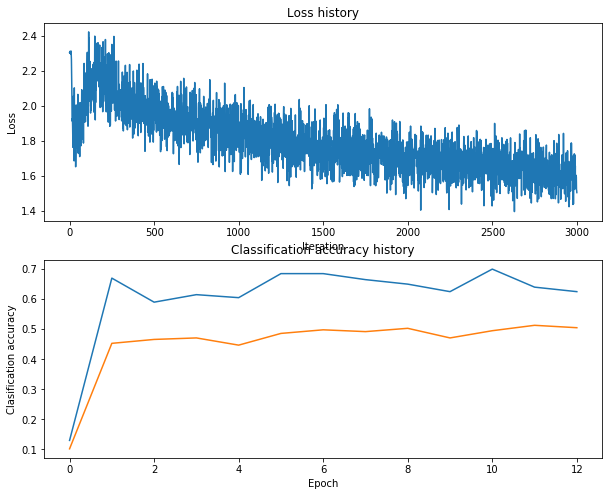

Validation accuracy:  0.528


In [33]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
results = {}
best_val = -1
from past.builtins import xrange
learning_rates = [1e0]
regularization_strengths = [1e-3, 3e-3]
neuronsInHidden = [500, 600, 700]

num_classes = 10

for numNeurons in neuronsInHidden:
    for rate in learning_rates:
        for l2Val in regularization_strengths:
            net = TwoLayerNet(input_dim, numNeurons, num_classes)
            # Train the network
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                        num_iters=3000, batch_size=200,
                        learning_rate = rate, learning_rate_decay=0.95,
                        reg=l2Val, verbose=True)
            
            # Plot the loss function and train / validation accuracies
            plt.subplot(2, 1, 1)
            plt.plot(stats['loss_history'])
            plt.title('Loss history')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')

            plt.subplot(2, 1, 2)
            plt.plot(stats['train_acc_history'], label='train')
            plt.plot(stats['val_acc_history'], label='val')
            plt.title('Classification accuracy history')
            plt.xlabel('Epoch')
            plt.ylabel('Clasification accuracy')
            plt.show()

            # Predict on the validation set
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            print('Validation accuracy: ', val_acc)
            train_acc = (net.predict(X_train_feats) == y_train).mean()
      
            if (best_val < val_acc):
                best_val = val_acc
                print (best_val)
                best_net = net
            results[(numNeurons, rate, l2Val)] = (train_acc, val_acc)

In [34]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.563


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!